In [1]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [2]:
train_dir = "Face Mask Dataset/Train"
test_dir = "Face Mask Dataset/Test"
val_dir = "Face Mask Dataset/Validation"

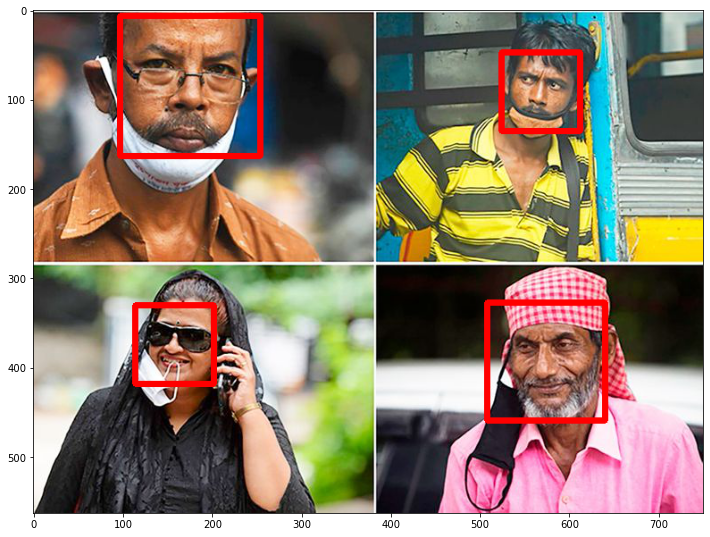

In [21]:
# Read a sample image
img = cv2.imread("trial_image3.png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (255, 0, 0), 5)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image

In [4]:
# Data preprocessing
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 2)                 40962     
                                                                 
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
early_stopping_callback = EarlyStopping(monitor='loss', patience=3)
early_stopping__acc_callback = EarlyStopping(monitor='accuracy', patience=3)
checkpoint_callback = ModelCheckpoint('checkpoint1.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='auto')

model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32,
    callbacks=[early_stopping_callback, early_stopping__acc_callback, checkpoint_callback]
)

Epoch 1/10


C:\Users\yeshu\AppData\Local\Temp/ipykernel_14736/1626919448.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


9/9 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8819
Epoch 1: accuracy improved from -inf to 0.88194, saving model to checkpoint.h5
9/9 [==============================] - 4s 236ms/step - loss: 0.3708 - accuracy: 0.8819
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9653
Epoch 2: accuracy improved from 0.88194 to 0.96528, saving model to checkpoint.h5
9/9 [==============================] - 2s 218ms/step - loss: 0.1967 - accuracy: 0.9653
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9688
Epoch 3: accuracy improved from 0.96528 to 0.96875, saving model to checkpoint.h5
9/9 [==============================] - 2s 211ms/step - loss: 0.1450 - accuracy: 0.9688
Epoch 4/10
9/9 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9931
Epoch 4: accuracy improved from 0.96875 to 0.99306, saving model to checkpoint.h5
9/9 [==============================] - 2s 210ms/step - lo

In [8]:
from keras.models import load_model
model = load_model('checkpoint.h5')

In [9]:
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 7s 272ms/step - loss: 0.0340 - accuracy: 0.9900
Model has a loss of 0.03 and accuracy 99.00%


In [10]:
from joblib import dump, load
dump(model, 'mask_detection_model.joblib') 

INFO:tensorflow:Assets written to: ram://8416ac19-0d31-43f9-9608-6fd52d2347d3/assets


INFO:tensorflow:Assets written to: ram://8416ac19-0d31-43f9-9608-6fd52d2347d3/assets


['mask_detection_model.joblib']

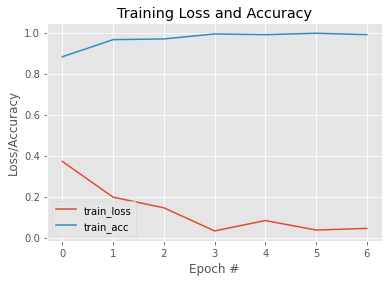

In [28]:
N = 7
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), model_history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

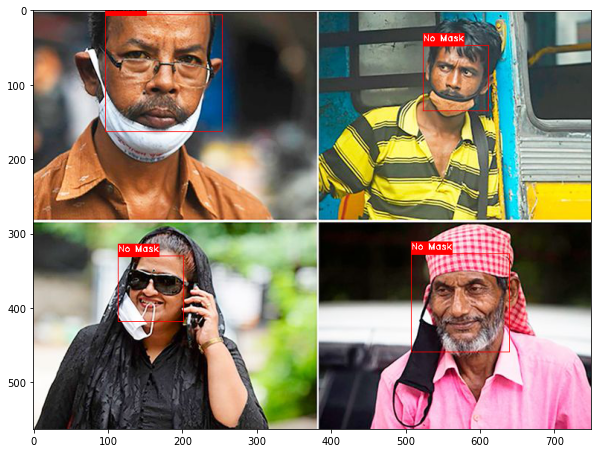

In [22]:
# label for mask detection
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size
    
    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  # draw rectangle

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image